In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

!pip install yfinance
import yfinance as yf

In [2]:
df = yf.download(tickers="BTC-USD",
                period="2y",
                interval="1h")
df = df.reset_index()
open_close = df[['Open', 'Close', 'Adj Close']]

num_features = 3
num_train = 15000
num_test = 2402

training_set = open_close.iloc[:num_train].values
test_set = open_close.iloc[num_train:].values

df.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of             Date          Open  ...     Adj Close      Volume
0     2019-02-22   3936.070068  ...   3938.399902           0
1     2019-02-22   3938.840088  ...   3943.989990     4834437
2     2019-02-22   3944.020020  ...   3956.330078     8121187
3     2019-02-22   3957.000000  ...   3950.889893     3696650
4     2019-02-22   3951.020020  ...   3955.429932     2641862
...          ...           ...  ...           ...         ...
17397 2021-02-21  56721.750000  ...  57598.328125  2904018944
17398 2021-02-21  57598.816406  ...  57371.312500  1286889472
17399 2021-02-21  57367.660156  ...  56990.644531   572403712
17400 2021-02-21  56985.445312  ...  57241.746094   193544192
17401 2021-02-21  57241.273438  ...  57241.273438           0

[17402 rows x 7 columns]>

In [3]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, num_train):
    X_train.append(training_set_scaled[i-60:i, 0:num_features])
    y_train.append(training_set_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

In [4]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, input_shape = (X_train.shape[1], num_features))))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

In [5]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 30, batch_size = 32)
model.summary()

Epoch 1/30
467/467 [==============================] - 7s 7ms/step - loss: 0.0094
Epoch 2/30
467/467 [==============================] - 3s 7ms/step - loss: 9.1187e-04
Epoch 3/30
467/467 [==============================] - 3s 7ms/step - loss: 7.2068e-04
Epoch 4/30
467/467 [==============================] - 3s 7ms/step - loss: 7.1082e-04
Epoch 5/30
467/467 [==============================] - 3s 7ms/step - loss: 5.6420e-04
Epoch 6/30
467/467 [==============================] - 3s 7ms/step - loss: 5.0427e-04
Epoch 7/30
467/467 [==============================] - 3s 7ms/step - loss: 4.2534e-04
Epoch 8/30
467/467 [==============================] - 3s 7ms/step - loss: 3.9316e-04
Epoch 9/30
467/467 [==============================] - 3s 7ms/step - loss: 3.4902e-04
Epoch 10/30
467/467 [==============================] - 3s 7ms/step - loss: 3.1393e-04
Epoch 11/30
467/467 [==============================] - 3s 7ms/step - loss: 2.9925e-04
Epoch 12/30
467/467 [==============================] - 3s 7ms/step 

In [6]:
# Getting the predicted stock price
dataset_train = open_close.iloc[:num_train]
dataset_test = open_close.iloc[num_train:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,num_features)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, num_test+60):
    X_test.append(inputs[i-60:i, 0:num_features])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

In [7]:
predicted_stock_price = model.predict(X_test)
predicted_padded = np.zeros(shape=(len(predicted_stock_price), num_features))
predicted_padded[:,1] = predicted_stock_price[:,0]
predicted_padded = sc.inverse_transform(predicted_padded)

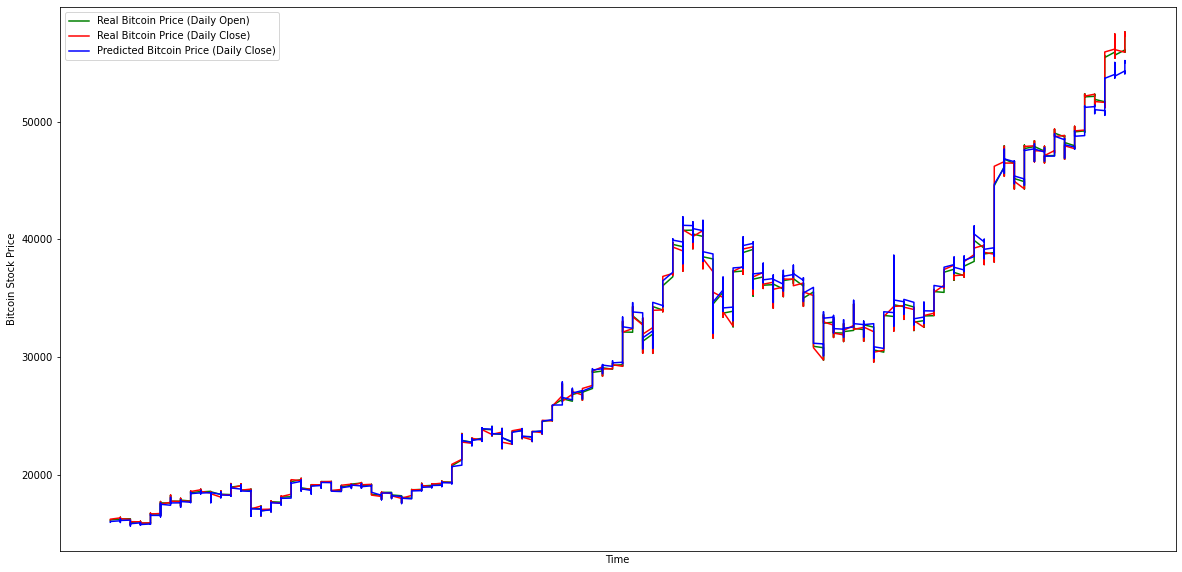

In [8]:
# Visualising the results
plt.figure(figsize=(20,10))

plt.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), df.iloc[num_train:, 1:2], color = 'green', label = 'Real Bitcoin Price (Daily Open)')
plt.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), df.iloc[num_train:, 4:5], color='red', label = 'Real Bitcoin Price (Daily Close)')
plt.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), predicted_padded[:,1], color = 'blue', label = 'Predicted Bitcoin Price (Daily Close)')

plt.xlabel('Time')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('Bitcoin Stock Price')
plt.legend()
plt.show()

In [9]:
error_sum = 0

for i in range(len(predicted_padded)):
    diff = abs(predicted_padded[i,1] - df.loc[num_train+i, 'Close']) / df.loc[num_train+i, 'Close']
    error_sum += diff

error_avg = error_sum / len(predicted_padded)
acc = 1 - error_avg
print(acc)

0.9899642883552724
